In [1]:
import cv2, pandas as pd, matplotlib.pyplot as plt
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
max_age = train['age_approx'].max()

In [2]:
!pip install -q efficientnet >> /dev/null
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [512,512,512,512,512]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [1,1,1,1,1]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [20]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')


connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [5]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS; GCS_PATH3 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    #GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
    #GCS_PATH3[i] = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
    GCS_PATH3[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH3[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH3[0] + '/test*.tfrec')))

In [6]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'],example['sex'],example['age_approx'],example['anatom_site_general_challenge'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'],example['sex'],example['age_approx'],example['anatom_site_general_challenge'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img
def prepare(ag):
    return ag/max_age

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img,s,ag,a,imgname_or_label: ((prepare_image(img, augment=augment, dim=dim), 
                                                     s,ag,a),imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [9]:
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import  Conv2D , MaxPooling2D , Activation,UpSampling2D,Flatten,Dense,Dropout,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
def psnet(x, beta=1.0, gama=0.0):
    return  K.sigmoid(beta * (x-gama))
class Psnet(tf.keras.layers.Layer):

    def __init__(self, beta=1.0, gama=0.0, **kwargs):
        super(Psnet, self).__init__(**kwargs)
        self.supports_masking = True
        self.beta = beta
        self.gama = gama
        self.__name__ = 'Psnet'

    def build(self, input_shape):
#        self.beta = k.variable(self.beta,
#                                      dtype=k.floatx(),
#                                      name='beta_factor')
#        self.gama = k.variable(self.gama,
#                                      dtype=k.floatx(),
#                                      name='gama_factor')
        self.beta = self.add_weight(name='beta',
                                        shape=(1,input_shape[1]),
                                        initializer='uniform',
                                        trainable=True,
                                        constraint=None)
        self.gama = self.add_weight(name='gama',
                                        shape=(1,input_shape[1]),
                                        initializer='uniform',
                                        trainable=True,
                                        constraint=None)

        super(Psnet, self).build(input_shape)

    def call(self, inputs, mask=None):
        return psnet(inputs, self.beta, self.gama)

    def get_config(self):
        config = {'beta': self.get_weights()[0],
                  'gama': self.get_weights()[1]} 
        base_config = super(Psnet, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    inp_csv0 = tf.keras.layers.Input(shape=(1,))
    inp_csv1 = tf.keras.layers.Input(shape=(1,))
    inp_csv2 = tf.keras.layers.Input(shape=(1,))
    inp_csv = tf.keras.layers.concatenate([inp_csv0,inp_csv1,inp_csv2])
    
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    xx = tf.keras.layers.Dense(64,activation='relu')(inp_csv)
    xx = tf.keras.layers.Dense(128,activation='relu')(xx)
    xx = tf.keras.layers.Dropout(0.5)(xx)
    
    to = tf.keras.layers.concatenate([x,xx])
    feat = int(to.shape[1])
    se = tf.keras.layers.Dense(int(feat/6),activation='relu')(to)
    se = tf.keras.layers.Dense(feat)(se)
    se = Psnet(beta=1.0,gama=0.0)(se)
    se = tf.multiply(to,se)
    pred = tf.keras.layers.Dense(1)(se)
    pred = Psnet(beta=1.0,gama=0.0)(pred)
    model = tf.keras.Model(inputs=[inp,inp_csv0,inp_csv1,inp_csv2],outputs=pred)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [11]:
def get_lr_callback(batch_size=8):
    lr_start   = 5e-6
    lr_max     = 1.25e-6 * REPLICAS * batch_size
    lr_min     = 1e-6
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

#########################
#### FOLD 1
#### Image Size 512 with EfficientNet B6 and batch_size 256
#### Using 2019 external data
#### Using 2018+2017 external data
#########################
165527552/165527152 [==============================] - 5s 0us/step
Predicting OOF with TTA...
Predicting Test with TTA...
no history
#########################
#### FOLD 2
#### Image Size 512 with EfficientNet B6 and batch_size 256
#### Using 2019 external data
#### Using 2018+2017 external data
#########################
Predicting OOF with TTA...
Predicting Test with TTA...
no history
#########################
#### FOLD 3
#### Image Size 512 with EfficientNet B6 and batch_size 256
#### Using 2019 external data
#### Using 2018+2017 external data
#########################
Predicting OOF with TTA...
Predicting Test with TTA...
no history
#########################
#### FOLD 4
#### Image Size 512 with EfficientNet B6 and batch_size 256
#### Using 2019 external data
#### Using 2018+2017 external data
#####

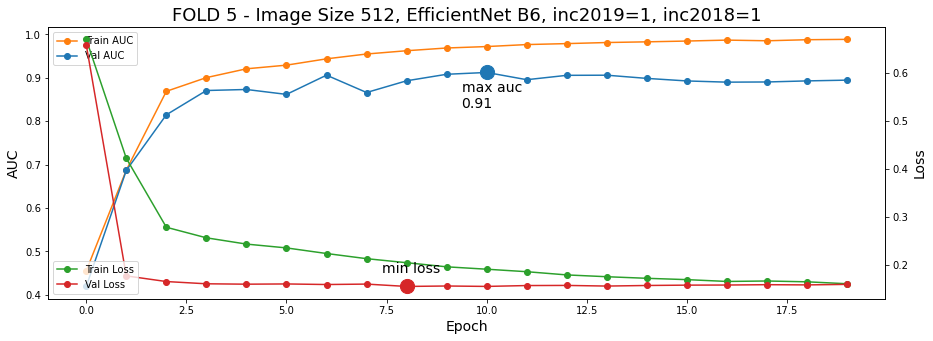

In [12]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
import os
VERBOSE = 0
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH3[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    if os.path.exists('../input/tpumodel2/fold-%i.h5'%fold):
        model.load_weights('../input/tpumodel2/fold-%i.h5'%fold)
    else:
        print('Training...')
        history = model.fit(
            get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                    dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
            epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
            steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
            validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                    repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
            verbose=VERBOSE
        )

        print('Loading best model...')
        model.load_weights('fold-%i.h5'%fold)

    # PREDICT OOF USING TTA
    try:
        print('Predicting OOF with TTA...')
        ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
        ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
        pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
        oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
        #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))

        # GET OOF TARGETS AND NAMES
        ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=True, return_image_names=True)
        oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
        oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
        ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                    labeled=False, return_image_names=True)
        oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    except:
        print('no history')
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    try:
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
        # PLOT TRAINING
        if DISPLAY_PLOT:
            plt.figure(figsize=(15,5))
            plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
            plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
            x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
            xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
            plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
            plt.legend(loc=2)
            plt2 = plt.gca().twinx()
            plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
            plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
            x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
            plt.ylabel('Loss',size=14)
            plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                    (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
            plt.legend(loc=3)
            plt.show()  
    except:
        print('no history')

In [13]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
#VERBOSE = 0
#DISPLAY_PLOT = True
#
#skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
#oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
#preds = np.zeros((count_data_items(files_test),1))
#
#for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
#    
#    # DISPLAY FOLD INFO
#    if DEVICE=='TPU':
#        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
#    print('#'*25); print('#### FOLD',fold+1)
#    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
#          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
#    
#    # CREATE Test SUBSETS
#    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH3[fold] + '/test*.tfrec')))
#    
#    # BUILD MODEL
#    K.clear_session()
#    with strategy.scope():
#        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
#    
#    print('Loading best model...')
#    model.load_weights('../input/tpumodel/fold-%i.h5'%fold)
#    
#    # PREDICT TEST USING TTA
#    print('Predicting Test with TTA...')
#    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
#            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
#    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
#    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
#    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    

In [14]:
# COMPUTE OVERALL OOF AUC
try:
    oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
    names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
    auc = roc_auc_score(true,oof)
    print('Overall OOF AUC with TTA = %.3f'%auc)

    # SAVE OOF TO DISK
    df_oof = pd.DataFrame(dict(
        image_name = names, target=true, pred = oof, fold=folds))
    df_oof.to_csv('oof.csv',index=False)
    df_oof.head()
except:
        print('no history')

Overall OOF AUC with TTA = 0.924


In [15]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for (img,s,ag,a), img_name in iter(ds.unbatch())])
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.024194
1443,ISIC_0052349,0.022347
3120,ISIC_0058510,0.019560
4870,ISIC_0073313,0.019533
5494,ISIC_0073502,0.027453
